In [1]:
import pandas as pd

df = pd.read_csv('datasets\goemotions_cleaned.csv')
df = df.drop(columns=['id','example_very_unclear','emotion_num'])
df.head()

,text,emotion
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,admiration
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [2]:
ekman_mapping = {
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"]
}

ekman_mapping["neutral"] = ["neutral"]


reverse_mapping = {value: key for key, values in ekman_mapping.items() for value in values}
df["emotion"] = df["emotion"].map(reverse_mapping)

print(df['emotion'].value_counts())
df.head()

emotion
joy         82847
neutral     55298
anger       28802
surprise    22904
sadness     14494
fear         3460
disgust      3420
Name: count, dtype: int64


,text,emotion
0,That game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,joy
2,"You do right, if you don't care then fuck 'em!",neutral
3,Man I love reddit.,joy
4,"[NAME] was nowhere near them, he was by the Fa...",neutral


In [3]:
from sklearn.utils import resample
target_count = min(df["emotion"].value_counts())

df_balanced = pd.concat([
    resample(group, replace=(len(group) < target_count), n_samples=target_count, random_state=42)
    for _, group in df.groupby("emotion")
])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced["emotion"].value_counts())
df_balanced.head()

emotion
sadness     3420
surprise    3420
fear        3420
disgust     3420
joy         3420
anger       3420
neutral     3420
Name: count, dtype: int64


,text,emotion
0,"Sorry guys, accidentally sold 10,000k",sadness
1,Related question: is there a level cap? EDIT: ...,surprise
2,"Other than family, I neither remember the last...",fear
3,*Ugh..* You are 23 and not married - leave.,disgust
4,I got grounded from reading once and it was th...,disgust


In [7]:
import nltk
import nlpaug.augmenter.word as naw
nltk.data.path.append("nltk_data")
nltk.download('averaged_perceptron_tagger_eng')

df_aug = df_balanced.copy()

syn_aug = naw.synonym.SynonymAug(aug_src='wordnet')
sub_aug = naw.random.RandomWordAug(action='substitute')
del_aug = naw.random.RandomWordAug(action='delete')
swap_aug = naw.random.RandomWordAug(action='swap')

def apply_augmentation(row):
    text = row['text']
    emotion = row['emotion']
    
    augmented_texts = [
        (syn_aug.augment(text), emotion),
        (sub_aug.augment(text), emotion),
        (del_aug.augment(text), emotion),
        (swap_aug.augment(text), emotion),
    ]
    
    return augmented_texts

augmented_data = []

for _, row in df_aug.iterrows():
    augmented_data.extend(apply_augmentation(row))

augmented_df = pd.DataFrame(augmented_data, columns=['text', 'emotion'])

print(augmented_df['emotion'].value_counts())
augmented_df.head()

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     c:\Users\HP\.conda\envs\emo\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


emotion
sadness     13680
surprise    13680
fear        13680
disgust     13680
joy         13680
anger       13680
neutral     13680
Name: count, dtype: int64


,text,emotion
0,"[Sorry guys, by chance sold decade, 000k]",sadness
1,"[_ guys, accidentally sold _, _]",sadness
2,"[Sorry guys, , 000k]",sadness
3,"[Sorry, guys accidentally 10 sold 000k,]",sadness
4,[Related doubt: is there a stage crown? EDIT: ...,surprise


In [8]:
merged_df = pd.concat([df_balanced, augmented_df])
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(merged_df['emotion'].value_counts())
merged_df.head(5)

emotion
anger       17100
disgust     17100
neutral     17100
surprise    17100
joy         17100
sadness     17100
fear        17100
Name: count, dtype: int64


,text,emotion
0,[No dont think that anywhere],anger
1,[dudes jelly..],disgust
2,[Is sex not a for basic need survival],neutral
3,[Where does this _ person _ _ hours _ come from?],surprise
4,You got this bro!!!!,joy


In [9]:
import string
from nltk.corpus import stopwords
import pandas as pd

merged_df['text'] = merged_df['text'].fillna('').astype(str)
merged_df['text'] = merged_df['text'].str.replace(r'[\[\]]', '', regex=True)

def remove_punctuations(text):
    punctuations = string.punctuation
    return text.translate(str.maketrans('', '', punctuations))

merged_df['text'] = merged_df['text'].apply(lambda x: remove_punctuations(x))

nltk.download('stopwords')
STOPWORDS  = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])
merged_df['text'] = merged_df['text'].apply(lambda x: remove_stopwords(x))

merged_df.head()



[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\HP\.conda\envs\emo\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,emotion
0,No dont think anywhere,anger
1,dudes jelly,disgust
2,Is sex basic need survival,neutral
3,Where person hours come,surprise
4,You got bro,joy


In [10]:
from collections import Counter
word_count = Counter()
for text in merged_df['text']:
    for word in text.split():
        word_count[word] += 1
        
word_count.most_common(10)

FREQUENT_WORDS = set(word for (word, wc) in word_count.most_common(3))
def remove_freq_words(text):
    return " ".join([word for word in text.split() if word not in FREQUENT_WORDS])

merged_df['text'] = merged_df['text'].apply(lambda x: remove_freq_words(x))
merged_df.head()

,text,emotion
0,No dont think anywhere,anger
1,dudes jelly,disgust
2,Is sex basic need survival,neutral
3,Where person hours come,surprise
4,You got bro,joy


In [11]:
RARE_WORDS = set(word for (word, wc) in word_count.most_common()[:-10:-1])

def remove_rare_words(text):
    return " ".join([word for word in text.split() if word not in RARE_WORDS])
merged_df['text'] = merged_df['text'].apply(lambda x: remove_rare_words(x))
merged_df.head()

,text,emotion
0,No dont think anywhere,anger
1,dudes jelly,disgust
2,Is sex basic need survival,neutral
3,Where person hours come,surprise
4,You got bro,joy


In [12]:
emotion_mapping = {emotion: idx for idx, emotion in enumerate(merged_df["emotion"].unique())}

merged_df["emotion"] = merged_df["emotion"].map(emotion_mapping)
print(emotion_mapping)
merged_df

{'anger': 0, 'disgust': 1, 'neutral': 2, 'surprise': 3, 'joy': 4, 'sadness': 5, 'fear': 6}


,text,emotion
0,No dont think anywhere,0
1,dudes jelly,1
2,Is sex basic need survival,2
3,Where person hours come,3
4,You got bro,4
...,...,...
119695,No boche husband know The way treat follow way...,0
119696,Another reasonableness instantly kill people c...,0
119697,Have silvered beat,4
119698,His left hand mightily fucked,5


In [13]:
augmented_with_original_data = pd.concat([df_balanced, augmented_df])
save_path = 'datasets\goemotions_cleaned_augmented.csv'
augmented_with_original_data.to_csv(save_path, index=False)

merged_df.to_csv('datasets\goemotions_cleaned_preprocessed.csv', index=False)

In [14]:
%pip install matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

Note: you may need to restart the kernel to use updated packages.


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    merged_df['text'], merged_df['emotion'], test_size=0.3, random_state=42
)

In [33]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [34]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

num_classes = merged_df['emotion'].nunique()

y_train = y_train.astype('category').cat.codes
y_test = y_test.astype('category').cat.codes

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Attention, GlobalAveragePooling1D

model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 lstm_4 (LSTM)               (None, 100, 128)          131584    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 7)                 455       
                                                                 
Total params: 1,465,607
Trainable params: 1,465,607
No

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [40]:
history = model.fit(
    X_train_pad, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stopping]
)

Epoch 1/20
1310/1310 [==============================] - 1495s 1s/step - loss: 1.8185 - accuracy: 0.2843 - val_loss: 1.5647 - val_accuracy: 0.4299
Epoch 2/20
1310/1310 [==============================] - 1352s 1s/step - loss: 1.4867 - accuracy: 0.4796 - val_loss: 1.4336 - val_accuracy: 0.4962
Epoch 3/20
1310/1310 [==============================] - 1283s 980ms/step - loss: 1.3351 - accuracy: 0.5503 - val_loss: 1.3742 - val_accuracy: 0.5243
Epoch 4/20
1310/1310 [==============================] - 1468s 1s/step - loss: 1.2317 - accuracy: 0.5920 - val_loss: 1.3287 - val_accuracy: 0.5446
Epoch 5/20
1310/1310 [==============================] - 1205s 920ms/step - loss: 1.1495 - accuracy: 0.6229 - val_loss: 1.3125 - val_accuracy: 0.5602
Epoch 6/20
1310/1310 [==============================] - 1355s 1s/step - loss: 1.0823 - accuracy: 0.6466 - val_loss: 1.2853 - val_accuracy: 0.5705
Epoch 7/20
1310/1310 [==============================] - 1182s 902ms/step - loss: 1.0209 - accuracy: 0.6689 - val_loss:

In [41]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1123/1123 [==============================] - 100s 89ms/step - loss: 1.2723 - accuracy: 0.5864
Test Loss: 1.2723
Test Accuracy: 0.5864


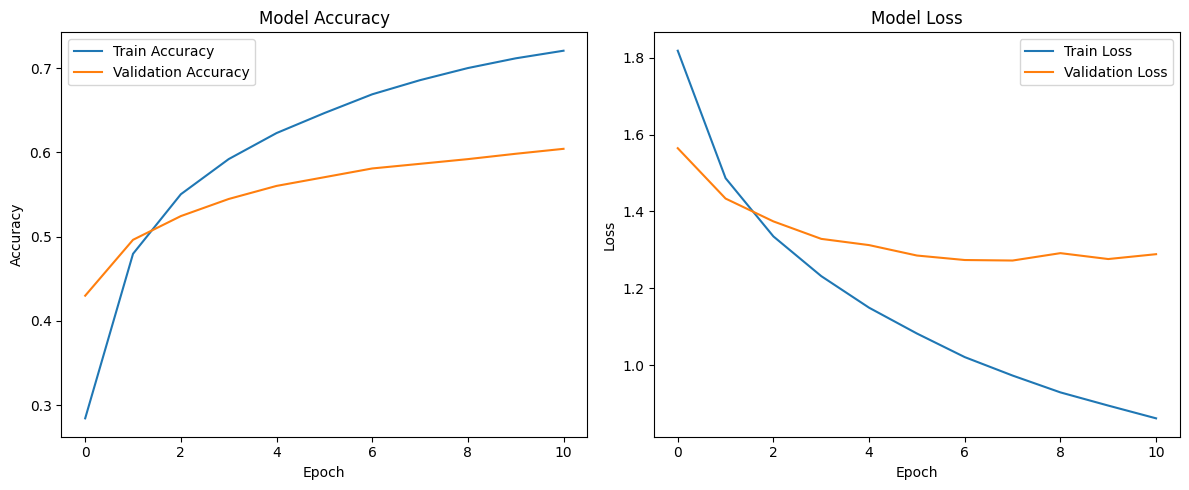

In [42]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('models/version3/training_history.png')
plt.show()

In [43]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.array(y_test)

1123/1123 [==============================] - 96s 85ms/step


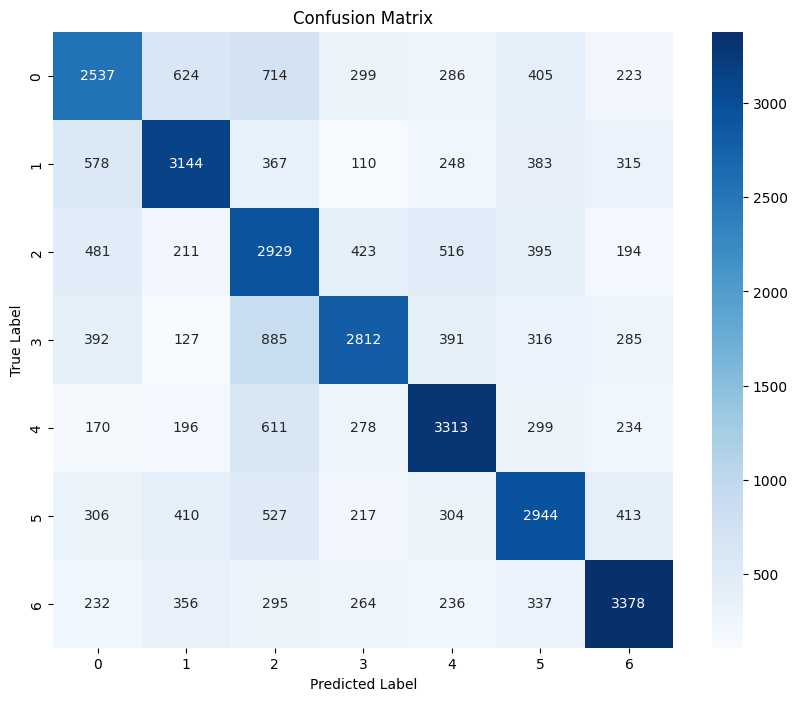

In [44]:
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('models/version3/confusion_matrix.png')
plt.show()

In [45]:
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.50      0.52      5088
           1       0.62      0.61      0.62      5145
           2       0.46      0.57      0.51      5149
           3       0.64      0.54      0.59      5208
           4       0.63      0.65      0.64      5101
           5       0.58      0.57      0.58      5121
           6       0.67      0.66      0.67      5098

    accuracy                           0.59     35910
   macro avg       0.59      0.59      0.59     35910
weighted avg       0.59      0.59      0.59     35910



In [46]:
model.save('models/version3/emotion_prediction_model.h5')

import pickle
with open('models/version3/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)